In [16]:
import uproot
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rc('font', size=18)

In [17]:
dfs = []
for file_path in glob.glob("output/*.root"):
    f = uproot.open(file_path)
    t = f.get("tree")
    dfs.append(t.pandas.df())
    
dfs = pd.concat(dfs)
els_df = dfs[dfs.lepton_id.abs() == 11]
mus_df = dfs[dfs.lepton_id.abs() == 13]

## 1. Sanity Checks

In [18]:
dfs.lepton_id.unique()

array([-13,  11, -11,  13])

In [19]:
np.sum(dfs.is_tight)

1869

In [20]:
np.sum(dfs.is_loose)

23208

## 2. Fake rate calculation

### 2.1 Plots

In [21]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2

    xyz = np.c_[
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, z), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            ("{"+fmt+"}").format(z),
            color=color,
            ha="center",
            va="center",
            fontsize=8,
            wrap=True,
        )

    return

def fake_rate_1D(loose_pts, tight_pts, label="", fmt="rs"):
    fig = plt.figure(figsize=(6.4,6.4))
    axes = plt.subplot(111)
    pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
    # Get histogram values
    loose_counts, _ = np.histogram(loose_pts, bins=pt_bin_edges)
    tight_counts, _ = np.histogram(tight_pts, bins=pt_bin_edges)
    fake_rates = np.divide(1.0*tight_counts, loose_counts, 
                           where=(loose_counts != 0))
    bin_widths = pt_bin_edges[1:]-pt_bin_edges[:-1]
    bin_centers = pt_bin_edges[:-1]+0.5*bin_widths
    # Plot error bars
    axes.errorbar(bin_centers, fake_rates, xerr=0.5*bin_widths, fmt=fmt, label=label);
    plt.ylim([0,0.6])
    axes.margins(0) # Remove axis margins
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    return

### 2.2 Fake rate binning

In [22]:
pt_bin_edges = np.array([10,15,20,25,30,35,45,55,70,90,120,150])
eta_bin_edges = np.array([0,0.5,1,1.5,2,2.5])
bin_edges = np.array([pt_bin_edges, eta_bin_edges])

### 2.3 Electrons

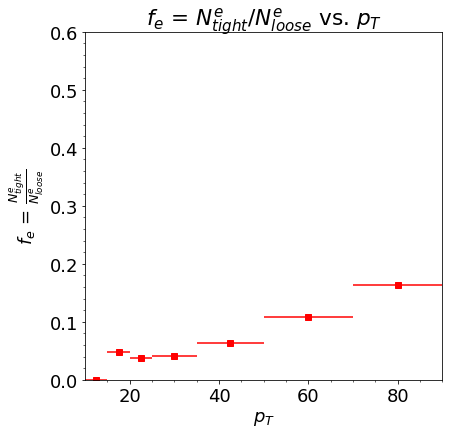

In [23]:
fake_rate_1D(els_df[els_df.is_loose].lepton_pt, els_df[els_df.is_tight].lepton_pt)
plt.title(r'$f_{e}$ = $N_{tight}^{e}$/$N_{loose}^{e}$ vs. $p_{T}$');
plt.ylabel(r'$f_{e}$ = $\frac{N_{tight}^{e}}{N_{loose}^{e}}$');
plt.xlabel(r'$p_{T}$');

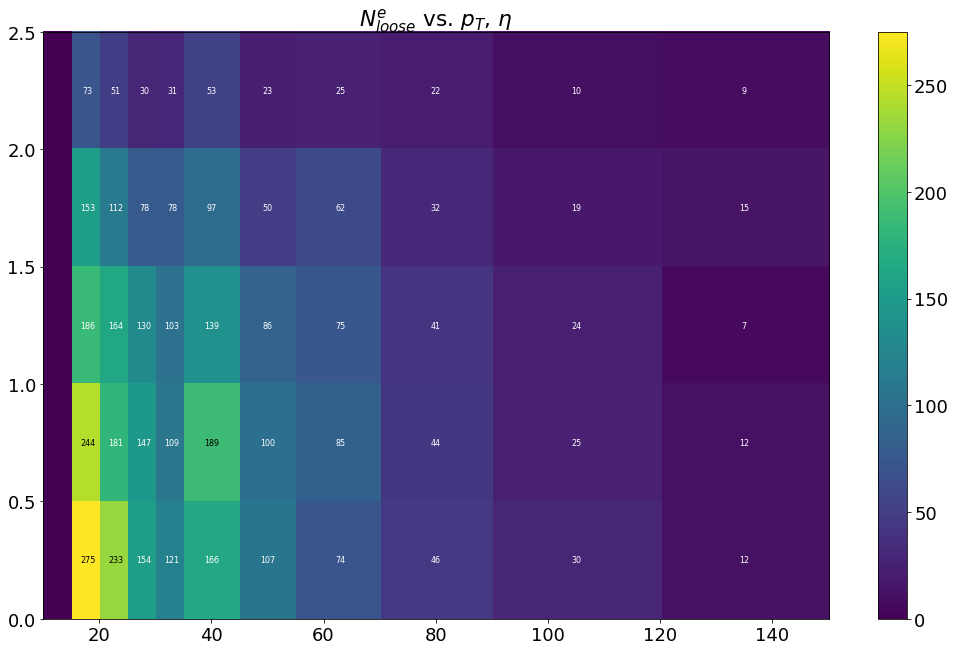

In [24]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)


loose_el_counts, _, _, _ = plt.hist2d(els_df.lepton_pt, els_df.lepton_eta, bins=bin_edges)
cbar = plt.colorbar()
bin_text(loose_el_counts.T, pt_bin_edges, eta_bin_edges, axes, cbar)

plt.title(r'$N_{loose}^{e}$ vs. $p_{T}$, $\eta$');

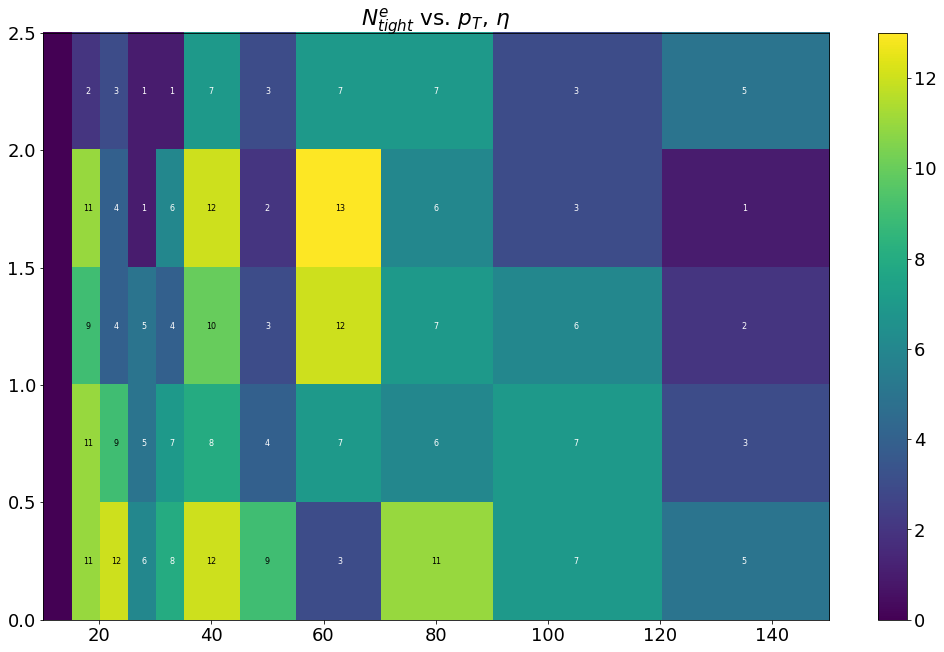

In [25]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)

tight_el_counts, _, _, _ = plt.hist2d(els_df[els_df.is_tight].lepton_pt, els_df[els_df.is_tight].lepton_eta, bins=bin_edges)
cbar = plt.colorbar();
bin_text(tight_el_counts.T, pt_bin_edges, eta_bin_edges, axes, cbar)

plt.title(r'$N_{tight}^{e}$ vs. $p_{T}$, $\eta$');

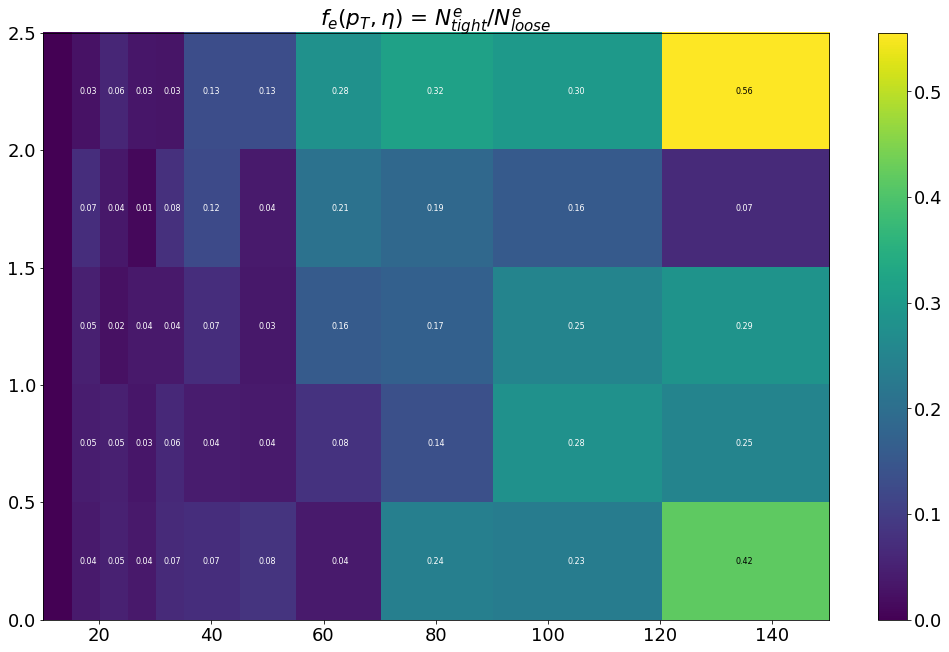

In [26]:
fake_el_rate_counts = np.divide(tight_el_counts.T, loose_el_counts.T, where=(loose_el_counts.T != 0))
fake_el_rate_counts[loose_el_counts.T == 0] = 0

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(pt_bin_edges, eta_bin_edges, fake_el_rate_counts)
cbar = fig.colorbar(c, ax=axes)
bin_text(fake_el_rate_counts, pt_bin_edges, eta_bin_edges, axes, cbar, fmt=":0.2f");

plt.title(r'$f_{e}(p_{T},\eta)$ = $N_{tight}^{e}$/$N_{loose}^{e}$');

### 2.4 Muons

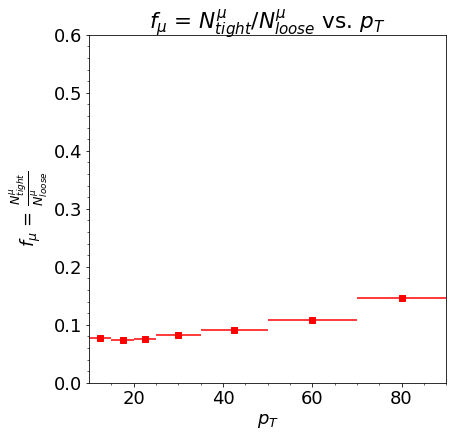

In [27]:
fake_rate_1D(mus_df[mus_df.is_loose].lepton_pt, mus_df[mus_df.is_tight].lepton_pt)
plt.title(r'$f_{\mu}$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$ vs. $p_{T}$');
plt.ylabel(r'$f_{\mu}$ = $\frac{N_{tight}^{\mu}}{N_{loose}^{\mu}}$');
plt.xlabel(r'$p_{T}$');

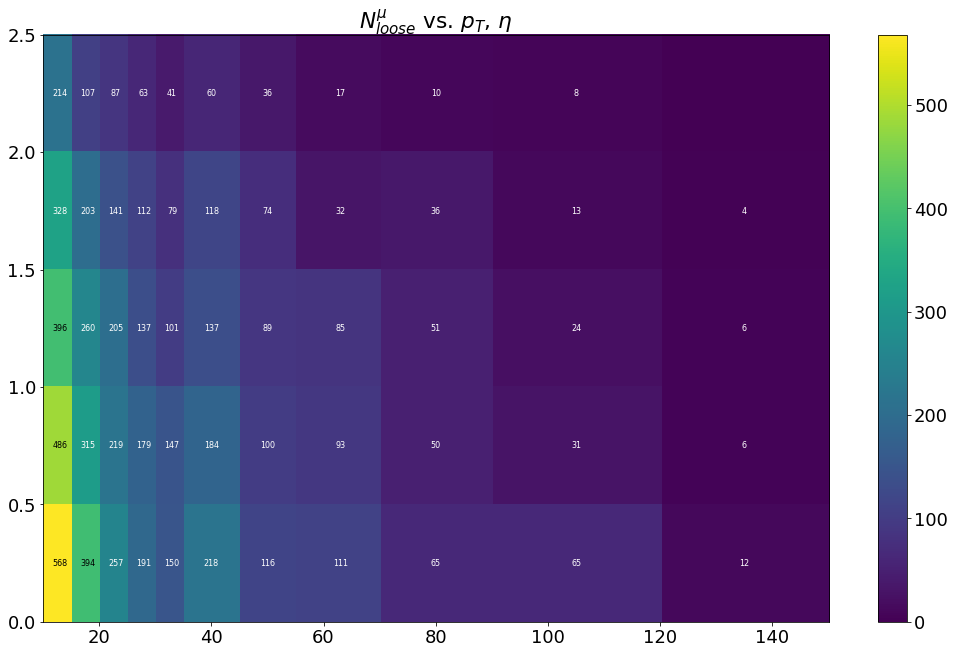

In [28]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)


loose_mu_counts, _, _, _ = plt.hist2d(mus_df.lepton_pt, mus_df.lepton_eta, bins=bin_edges)
cbar = plt.colorbar()
bin_text(loose_mu_counts.T, pt_bin_edges, eta_bin_edges, axes, cbar)

plt.title(r'$N_{loose}^{\mu}$ vs. $p_{T}$, $\eta$');

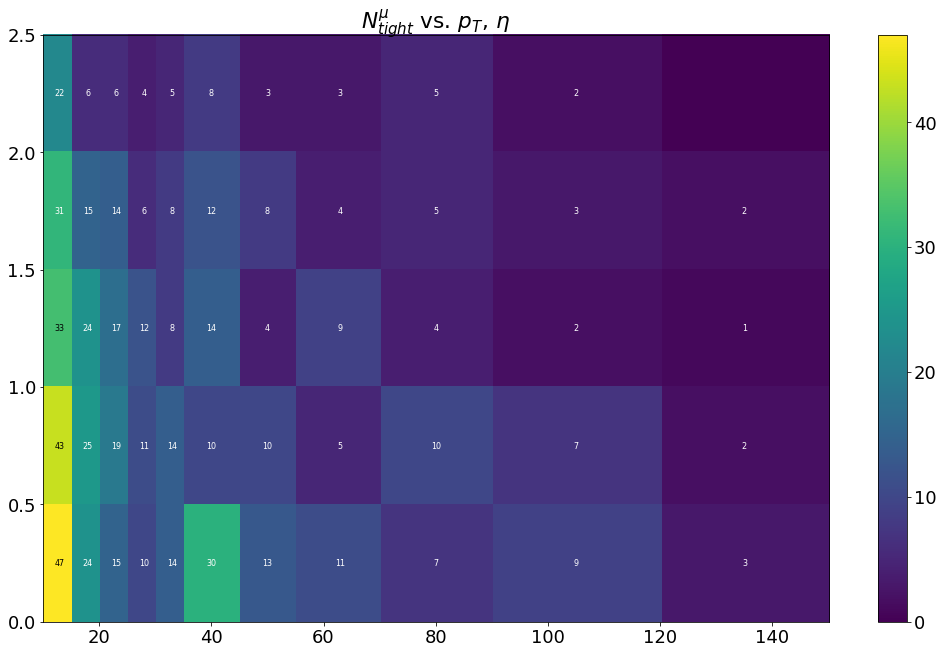

In [29]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)

tight_mu_counts, _, _, _ = plt.hist2d(mus_df[mus_df.is_tight].lepton_pt, mus_df[mus_df.is_tight].lepton_eta, bins=bin_edges)
cbar = plt.colorbar();
bin_text(tight_mu_counts.T, pt_bin_edges, eta_bin_edges, axes, cbar)

plt.title(r'$N_{tight}^{\mu}$ vs. $p_{T}$, $\eta$');

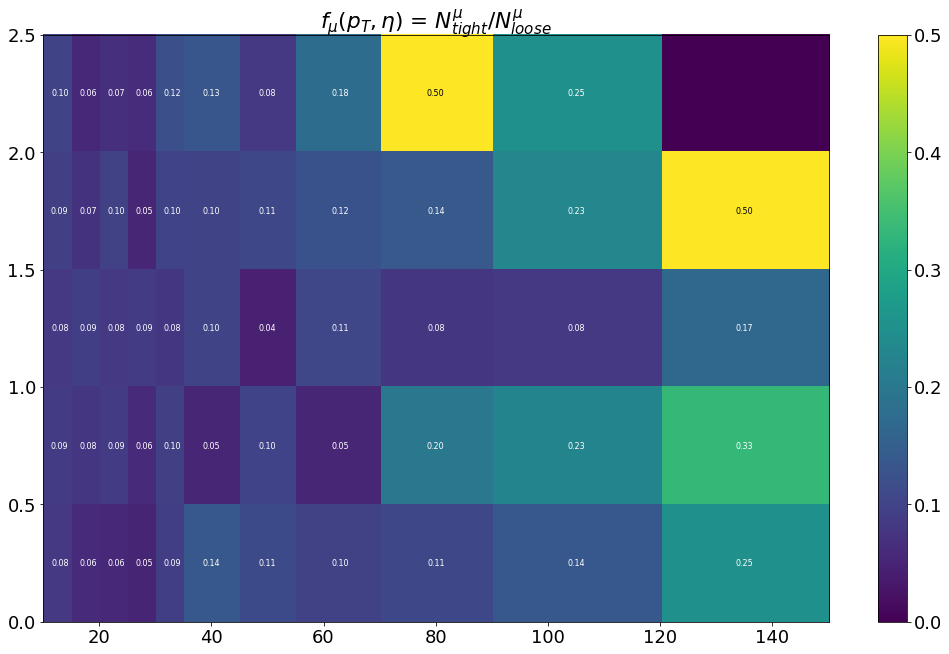

In [30]:
fake_mu_rate_counts = np.divide(tight_mu_counts.T, loose_mu_counts.T, where=(loose_mu_counts.T != 0))
fake_mu_rate_counts[loose_mu_counts.T == 0] = 0

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(pt_bin_edges, eta_bin_edges, fake_mu_rate_counts)
cbar = fig.colorbar(c, ax=axes)
bin_text(fake_mu_rate_counts, pt_bin_edges, eta_bin_edges, axes, cbar, fmt=":0.2f");

plt.title(r'$f_{\mu}(p_{T},\eta)$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$');